# Assignment 2

This notebook is the solution to HW2, written by Yaniv Bin and Tair Hakman.

We first would like to import all the required modules in order for our code to run properly:

In [2]:
from os.path import abspath, dirname, join
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gzip, string, nltk
from nltk.corpus import conll2002
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

Now we can go ahead and solve the assignment. 

## Part 1

Our first task is identifying complex words. In order to do so we will use the data provided. 
first we need to load the data using the provided functions. 
<br>(For a better flow we modified the skeleton code within the notebook, but we added the edit into the skeleton file as well) 

In [2]:
def load_file(data_file):
    words = []
    labels = []   
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

And loading the data:

In [108]:
training_file = abspath(join(dirname("__file__"), "data/complex_words_training.txt"))
development_file = abspath(join(dirname("__file__"), "data/complex_words_development.txt"))
test_file = abspath(join(dirname("__file__"), "data/complex_words_test_unlabeled.txt"))

Now that we have the data we may start working on the actual assignment. 

### Part 1.1 - Evaluation Matrics

Usually in order to evaluate how well a classifcation algorithm works we use three mesures - 
- Precision: Mesure how 'useful' the results are (how many are hits and how many are miss)
- Recall: Mesure how 'complete' the results are (out off all the actually possible results, how many did we hit)
- Fscore: Mesure the balance between the Precision and Recall

We would like to implement functions that compose each of these matrics 

We will start by calculating the precision - the precision is defined as:
<br>$precision = \frac{tp}{tp + fp}$
<br>Where $tp$ stands for true-positive meaning a hit, and $fp$ stands for false-positive meaning the prediction is positive but it's actually a false alarm

In [43]:
## Input: y_pred, a list of length n with the predicted labels,
## y_true, a list of length n with the true labels

## Calculates the precision of the predicted labels
def get_precision(y_pred, y_true):
    positive_hits_array = np.array([(1 if(y_pred[i] == y_true[i] == 1) else 0) for i in range(len(y_pred))])
    positive_hits = np.count_nonzero(positive_hits_array == 1)
    total_positive = np.count_nonzero(np.array(y_pred) == 1)
    precision = float(positive_hits) / float(total_positive)
    return precision

In [45]:
y_pred = [0, 1, 1, 0]
y_true = [0, 0, 1, 1]
get_precision(y_pred, y_true)

0.5

The second mesure we will implement is the recall, calculated as follows
<br>$recall = \frac{tp}{tp + fn}$
<br>Where $fn$ stands for false-negative, meaning the prediction is negative also it should have been positive(a miss).

In [48]:
## Calculates the recall of the predicted labels
def get_recall(y_pred, y_true):
    positive_hits_array = np.array([(1 if(y_pred[i] == y_true[i] == 1) else 0) for i in range(len(y_pred))])
    positive_hits = np.count_nonzero(positive_hits_array == 1)
    total_positive = np.count_nonzero(np.array(y_true) == 1)
    recall = float(positive_hits) / float(total_positive)
    return recall

In [51]:
y_pred = [0, 1, 1, 0]
y_true = [1, 0, 1, 1]
get_recall(y_pred, y_true)

0.3333333333333333

and the last measure we want to implement is the fscore(also known as f1) which is calculated as:
<br>$F = 2 * \frac{precision*recall}{precision + recall}$

In [53]:
## Calculates the f-score of the predicted labels
def get_fscore(y_pred, y_true):
    precision = get_precision(y_pred, y_true)
    recall = get_recall(y_pred, y_true)
    fscore = 2 * float(precision * recall) / float(precision + recall)
    return fscore

In [54]:
y_pred = [0, 1, 1, 0]
y_true = [1, 0, 1, 1]
get_fscore(y_pred, y_true)

0.4

For our own good we would also like to implement a function that prints out all the information given the two arrays:

In [55]:
def test_predictions(y_pred, y_true):
    print("Precision:", get_precision(y_pred, y_true))
    print("Recall:", get_recall(y_pred, y_true))
    print("Fscore:", get_fscore(y_pred, y_true))

In [56]:
y_pred = [0, 1, 1, 0]
y_true = [1, 0, 1, 1]
test_predictions(y_pred, y_true)

Precision: 0.5
Recall: 0.3333333333333333
Fscore: 0.4


Now after implementing the functions, we can go on and implement actual classifiers. 

### Part 1.2 - Baselines

#### Part 1.2.1 - All complex

The first classifier we will implement is a very simple one that classifies all the words as complex no matter what they actually are.

In [58]:
## Labels every word complex
def all_complex(data_file):
    words, actual_labels = load_file(data_file)
    all_complex_labels = np.ones((len(words),), dtype=int)
    precision = get_precision(all_complex_labels, actual_labels)
    recall = get_recall(all_complex_labels, actual_labels)
    fscore = get_fscore(all_complex_labels, actual_labels)
    performance = [precision, recall, fscore]
    return performance

And we shall test it with each of the files:

In [62]:
tr_precision, tr_recall, tr_fscore = all_complex(training_file)
print("Training Precision: {} \nTraining Recall: {} \nTraining Fscore: {}".format(tr_precision, tr_recall, tr_fscore))

Training Precision: 0.43275 
Training Recall: 1.0 
Training Fscore: 0.604083057058105


In [63]:
dv_precision, dv_recall, dv_fscore = all_complex(development_file)
print("Dev Precision: {} \nDev Recall: {} \nDev Fscore: {}".format(dv_precision, dv_recall, dv_fscore))

Dev Precision: 0.418 
Dev Recall: 1.0 
Dev Fscore: 0.5895627644569816


One can note how the recall of this model is always 1 - that makes sense because although it probably has a lot of false positives - it never "miss" in terms of false negtive because it's always positive. 

#### Part 1.2.2 - word length

The second baseline we will implement is a word length based one, which gives a positive value to a word if it's length goes past a certain threshold.

In [94]:
### 1.2.2: Word length thresholding
def word_length_baseline(data_file, threshold):
    words, actual_labels = load_file(data_file)
    threshold_labels = [(1 if(len(word) >= threshold) else 0) for word in words]
    
    precision = get_precision(threshold_labels, actual_labels)
    recall = get_recall(threshold_labels, actual_labels)
    fscore = get_fscore(threshold_labels, actual_labels)
    preformance = [precision, recall, fscore]
    return preformance

We want to run this for both the training dataset and the development dataset for different threshold values, and plot this:

For threshold - 0 the fscore is 0.604083057058105
For threshold - 1 the fscore is 0.604083057058105
For threshold - 2 the fscore is 0.604083057058105
For threshold - 3 the fscore is 0.604083057058105
For threshold - 4 the fscore is 0.6142322097378278
For threshold - 5 the fscore is 0.6442307692307692
For threshold - 6 the fscore is 0.680399235506477
For threshold - 7 the fscore is 0.7018976699495555
For threshold - 8 the fscore is 0.6919592298980747
For threshold - 9 the fscore is 0.6276346604215458
For threshold - 10 the fscore is 0.4877663772691396
For threshold - 11 the fscore is 0.33770937075599816
For threshold - 12 the fscore is 0.21656686626746505
For threshold - 13 the fscore is 0.12539851222104145
For threshold - 14 the fscore is 0.07362637362637363
[1.         1.         1.         1.         0.99480069 0.96764876
 0.9254766  0.8440208  0.70595032 0.5418833  0.35701906 0.21548238
 0.12536106 0.06816869 0.03870595]
[0.43275    0.43275    0.43275    0.43275    0.44427245 0.4828

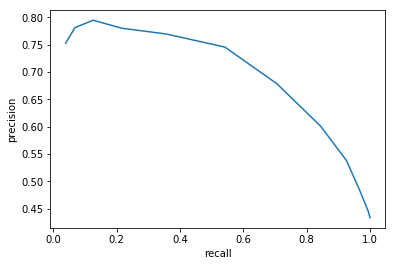

In [105]:
precisions = np.zeros(15)
recall = np.zeros(15)
for i in range(15):
    tprecision, trecall, tfscore = word_length_baseline(training_file, i)
    precisions[i] = tprecision
    recall[i] = trecall
    print("For threshold - {} the fscore is {}".format(i, tfscore))

plt.figure(1)
plt.plot(recall, precisions)
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

For threshold - 0 the fscore is 0.5895627644569816
For threshold - 1 the fscore is 0.5895627644569816
For threshold - 2 the fscore is 0.5895627644569816
For threshold - 3 the fscore is 0.5895627644569816
For threshold - 4 the fscore is 0.5971428571428571
For threshold - 5 the fscore is 0.6313364055299538
For threshold - 6 the fscore is 0.6791489361702128
For threshold - 7 the fscore is 0.7125984251968505
For threshold - 8 the fscore is 0.7065592635212887
For threshold - 9 the fscore is 0.624484181568088
For threshold - 10 the fscore is 0.4694214876033058
For threshold - 11 the fscore is 0.3500931098696462
For threshold - 12 the fscore is 0.2139917695473251
For threshold - 13 the fscore is 0.11013215859030837
For threshold - 14 the fscore is 0.05949656750572082


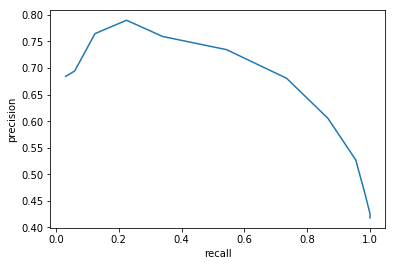

In [106]:
precisions = np.zeros(15)
recall = np.zeros(15)
for i in range(15):
    dprecision, drecall, dfscore = word_length_baseline(development_file, i)
    precisions[i] = dprecision
    recall[i] = drecall
    print("For threshold - {} the fscore is {}".format(i, dfscore))

plt.figure(2)
plt.plot(recall, precisions)
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

We can see that once the recall is big the precision is small and vice versa, that's because the two complement eachother. 

Now we can go about building the "ideal" threshold classifier:

In [102]:
## Finds the best length threshold by f-score, and uses this threshold to
## classify the training and development set
def word_length_threshold(training_file, development_file):
    best_tfscore = 0.0
    best_i = 1
    i = 1
    while(True):
        tprecision, trecall, tfscore = word_length_baseline(training_file, i)
        if(tfscore < best_tfscore):
            break
        else:
            best_i = i
            i += 1
            best_tfscore = tfscore
            
    tprecision, trecall, tfscore = word_length_baseline(training_file, best_i)
    dprecision, drecall, dfscore = word_length_baseline(development_file, best_i)
    training_performance = [tprecision, trecall, tfscore]
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

In [103]:
training_performance, development_performance = word_length_threshold(training_file, development_file)
tr_precision, tr_recall, tr_fscore = training_performance
dv_precision, dv_recall, dv_fscore = development_performance
print("Training Precision: {} \nTraining Recall: {} \nTraining Fscore: {}".format(tr_precision, tr_recall, tr_fscore))
print("Dev Precision: {} \nDev Recall: {} \nDev Fscore: {}".format(dv_precision, dv_recall, dv_fscore))

Training Precision: 0.6007401315789473 
Training Recall: 0.8440207972270364 
Training Fscore: 0.7018976699495555
Dev Precision: 0.6053511705685619 
Dev Recall: 0.8660287081339713 
Dev Fscore: 0.7125984251968505


#### Part 1.2.3 - Word Frequency 

## Part 3

In this task, we will create a NER (Named Entity Recognition) model that recognizes names of persons, organizations and other entities in text. We will use the CoNLL 2002 dataset. As we build the code, we will use the Spanish version of the dataset. At the end of every segment, we'll test our functions on the Dutch dataset and compare the differences. 
First, we will import the data:

In [3]:
train_sents = list(conll2002.iob_sents('esp.train'))
test_sents = list(conll2002.iob_sents('esp.testa'))
d_train_sents = list(conll2002.iob_sents('ned.train'))
d_test_sents = list(conll2002.iob_sents('ned.testa'))

Let's understand how our dataset is represented. Each of the two datasets is imported as a list. Each element in the list is a **sentence**. Let's look at an example of the first element (and hence, first sentence) in the first dataset: 

In [4]:
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

As we can see, the sentence represented by a list of word. A word is **also** represented by a list, that contains three elements: the word itself, it's POS (Part of Speech) tagging, and it's correct NER tagging. 

Now that we understand our data, it's time to extract features. We'll be looking for word level features, and in this step we'll be looking at each word separately. Those are the features we've chosen to extract for every word:

Form (The actual word), POS tagging, is number, does it contain a number, does it begin with a capital letter, is it all capital letters, is it a punctuation char, the first one, two and three letters of the word, the last one, two and three letters in of the word. 
Here's the code for feature extraction:

In [5]:
def hasNumbers(str):
    return any(c.isdigit() for c in str)

def get_word_features (word):
    w = word[0]
    features = {
     "form": w,
     "pos": word[1],
     "is_number": w.isdigit(),
     "contains_number": hasNumbers(w),
     "beginCapital": w[0].isupper(),
     "allCaps": w.isupper(),
     "isPunc": w in string.punctuation,
     "firstLetter": w[0],
     "first2Letters": w[0:2],
     "first3Letters": w[0:3],
     "lastLetter": w[-1],
     "last2Letters": w[-2:],
     "last3Letters": w[-3:]
    }
    return features

And here's an example on the word 'Melbourne':

In [6]:
get_word_features(train_sents[0][0])

{'allCaps': False,
 'beginCapital': True,
 'contains_number': False,
 'first2Letters': 'Me',
 'first3Letters': 'Mel',
 'firstLetter': 'M',
 'form': 'Melbourne',
 'isPunc': False,
 'is_number': False,
 'last2Letters': 'ne',
 'last3Letters': 'rne',
 'lastLetter': 'e',
 'pos': 'NP'}

So now we have our features, it's time to train our model. We will be using Scikit's DictVectorizer data structure to keep our data, and it's logistic regression implementation for the training. Those methods requires two seperate lists of identical size, where every element represents one word in the corpus. The first list (X) keeps the list of features for every word, and the second list (y) has the NER tagging of the word - which is the answer our model will be trying to guess.

Here is the code that creates those lists:

In [7]:
def get_corpus_features (corpus):
#gets a corpus, returns a list of features for every word
    X=[]
    for sent in corpus:
        X+=[get_word_features(w) for w in sent]
    return X

def get_y (corpus):
    y=[]
    for sent in corpus:
        y+=[w[2] for w in sent]
    return y

Note that, in addition to the obvious effect of getting features/NER taggings, those functions also transform our data from a list of **sentences** to a list of **words** - so our output is a big list of all the words, not divided to sentences anymore.

Now we'll create our DictVectorizer and train our model:

In [8]:
def train(train_sents, v, features):
    y = get_y (train_sents)
    X = v.fit_transform(features)
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, y)
    return clf

v = DictVectorizer(sparse=True)
features = get_corpus_features(train_sents)
clf = train(train_sents, v, features)

The **DictVecotizer** structure and it's fit_transform method, transforms the features list to a matrix. Each row in the matrix represents a word, and each column represents a feature. Each cell M(i,j) includes the corresponding numerical value for feature j in word i.
But what if the features are non-numerical? Boolean data easily transforms to 1 (True) or 0 (False), but strings are a bit more complicated to encode. DictVectorizer's solution is to create a separate boolean feature for every string it encounters. For example, for the word "Melbourne", rather than the "firstLetter" feature, it will create a new boolean feature: "firstLetter=M", that will be True for every word that begins in M, and False otherwise.

This is a good solution, but it means that each word, prefix or suffix of length 1,2,3, and other string features - a specific feature will be created. In othe words, our matrix is getting really big. For the first sentence alone (11 words), 75 features are created. For the entire dataset (264715 words), the matrix will be huge - in fact, too huge for the computer's memory (or at least, *my* computer's memory) to handle.

That's why we use a **sparse** version of the matrix. The sparse data structure takes advantage of the fact that most of the matrix (typically above 99%) is zeros - the word "Melbourne" for example will have 0 in every prefix feature other than "firstLetter=M", "first2Letters=Me" and "first3Letters=Mel" (same applies for suffix). So the sparse data structre, rather than actually save all those zeros, only keeps the non-zero values and cells, and assumes zero everywhere else.

So now we have our sparse matrix X, and our target values y, it's time to create our classifier (clf) using Scikit's logistic regression implementation. It's time to test this model on the our test set:

In [9]:
def predict (clf, v, test_features):
    X2 = v.transform(test_features)
    return clf.predict(X2)

test_features = get_corpus_features(test_sents)
y_predict = predict (clf, v, test_features)
y_true = get_y (test_sents)

This function is fairly straight forward, but it's interesting to note the *transform* method used. We create a sparse feature matrix for the test set, but it will not be in the same size as the original matrix for the train data. However, the *predict* method demands that the train and test matrixes will have the same number of features. 
The transform method transforms the test_features matrix to the same size as the train_features - by adding empty columns for features encountered in the training data, but not the test data. However, this also means there's some information loss - as features that were encountered in the test data but not the train data are "silently ignored".

So now we have our predictions, it's time to evaluate how well we did. We can do this by several different methods. The easiest of which will be to calculate the accuracy score:

In [11]:
def accuracy (x,y):
    correct = sum([1 if x[i]==y[i] else 0 for i in range(len(x))])
    return correct / len(x)

accuracy(y_predict, y_true)

0.9295391417720084

So almost 93%, not too bad but we will try to do better. We also have more tools to analyze our errors. For a start, we can simply print all the errors and manually look at them:

In [23]:
def get_errors (x,y,test_sents):
    features = get_corpus_features(test_sents)
    errors=[]
    for i in range(len(x)):
        if x[i]!=y[i]:
            errors.append((y[i], x[i], features[i].get("form")))
    return sorted(errors)
        
errors = get_errors (y_predict,y_true,test_sents)
for i in range(20):
    print('correct=%-8s guess=%-8s word=%-30s' % (errors[i][0],errors[i][1],errors[i][2]))
    
#we only print the first 20 errors as examples

correct=B-LOC    guess=B-MISC   word=K-2                           
correct=B-LOC    guess=B-MISC   word=K-2                           
correct=B-LOC    guess=B-MISC   word=K-2                           
correct=B-LOC    guess=B-MISC   word=K-2                           
correct=B-LOC    guess=B-MISC   word=MADRID                        
correct=B-LOC    guess=B-MISC   word=Región                        
correct=B-LOC    guess=B-MISC   word=SEVILLA                       
correct=B-LOC    guess=B-MISC   word=SEVILLA                       
correct=B-LOC    guess=B-MISC   word=Tíbet                         
correct=B-LOC    guess=B-MISC   word=Yacuiba-Río                   
correct=B-LOC    guess=B-ORG    word=ACEUCHAL                      
correct=B-LOC    guess=B-ORG    word=Aceuchal                      
correct=B-LOC    guess=B-ORG    word=Auditorio                     
correct=B-LOC    guess=B-ORG    word=Austria                       
correct=B-LOC    guess=B-ORG    word=Autoridad  

We can also take a look at the confusion matrix:
(We'll also print the NER tags in order, because the Scikit confusion matrix does not include labels).

In [12]:
print (set(y_true))
print (metrics.confusion_matrix(y_true, y_predict))

{'I-PER', 'B-ORG', 'I-LOC', 'B-PER', 'B-MISC', 'B-LOC', 'I-MISC', 'O', 'I-ORG'}
[[  779    10    77    30     3     5    30    15    35]
 [   17   214    42     8     0    32    26    14    92]
 [  186    45  1201    67     1    12    52    53    83]
 [  107     5    49   739    20    11    25   233    33]
 [   24     5     9    30   131     5    37    18    78]
 [   51    33    34    21    12   126    55    29   293]
 [  159    53   121    41    18    68   382    78   446]
 [   83     5    36   142    12    12    25   477    67]
 [    7    35    72    17     1    35    35     9 45145]]


Scikit also offers an handy tool called a classification report:

In [13]:
print(metrics.classification_report(y_true, y_predict))

             precision    recall  f1-score   support

      B-LOC       0.55      0.79      0.65       984
     B-MISC       0.53      0.48      0.50       445
      B-ORG       0.73      0.71      0.72      1700
      B-PER       0.67      0.60      0.64      1222
      I-LOC       0.66      0.39      0.49       337
     I-MISC       0.41      0.19      0.26       654
      I-ORG       0.57      0.28      0.38      1366
      I-PER       0.52      0.56      0.53       859
          O       0.98      1.00      0.99     45356

avg / total       0.92      0.93      0.92     52923



It seems we are doing a very good job with recognizing O's, but we struggle with other tags. In general, B tags seem to have better score than I tags, while MISC category seems to be the most difficult to classify. It also means that our 93% accuracy score is misleading - the score is relatively high because we are good in recognizing O's (which is the majority of the dataset), but when it comes to the classification of other tags, our accuracy is much lower.

Let's check our model on the Dutch dataset as well:

In [14]:
d_features = get_corpus_features(d_train_sents)
d_clf = train(d_train_sents, v, d_features)
d_test_features = get_corpus_features(d_test_sents)
d_y_predict = predict (d_clf, v, d_test_features)
d_y_true = get_y (d_test_sents)
print ("accuracy:", accuracy (d_y_predict,d_y_true))
print (metrics.classification_report(d_y_true, d_y_predict))

accuracy: 0.9508053174834824
             precision    recall  f1-score   support

      B-LOC       0.65      0.60      0.62       479
     B-MISC       0.74      0.60      0.66       748
      B-ORG       0.72      0.45      0.55       686
      B-PER       0.55      0.70      0.62       703
      I-LOC       0.37      0.23      0.29        64
     I-MISC       0.42      0.23      0.30       215
      I-ORG       0.69      0.37      0.48       396
      I-PER       0.38      0.45      0.41       423
          O       0.98      1.00      0.99     33973

avg / total       0.95      0.95      0.95     37687



It seems our Dutch model is doing slightly better than the Spanish one, but it's still prone to similar mistakes - once again we recognize very high success rates among O's (which are the big majority of the dataset), I tags are more difficult to predict than B tags, and "Misc" category is still problematic. 
One noticeable difference is that the Dutch model seems to struggle with Location names (0.29 fscore on I-LOC - even lower than I-MISC), which the Spanish model did better on. A possible explanation is insufficient training data - the Dutch dataset only had 64 I-LOC tags, which is much lower than other tags. 
The support column refers to the test dataset and not the training dataset, but a check on the training dataset confirms that I-LOC tags are indeed relatively rare.

So now, we will try to imrove our overall model by using more than just word-specific features - we'll be looking at features of the previous and following word. Here's our updated *get_word_features2* method, which now receives three arguments (the previous and next word, in addition to the current one) and extracts all features for all 3 words: 

In [15]:
def get_word_features2 (word, prev, next):
#also includes information about next and previous word
    w = word[0]
    p = prev[0]
    n = next[0]
    features = {
     "form": w,
     "pos": word[1],
     "is_number": w.isdigit(),
     "contains_number": hasNumbers(w),
     "beginCapital": w[0].isupper(),
     "allCaps": w.isupper(),
     "isPunc": w in string.punctuation,
     "firstLetter": w[0],
     "first2Letters": w[0:2],
     "first3Letters": w[0:3],
     "lastLetter": w[-1],
     "last2Letters": w[-2:],
     "last3Letters": w[-3:],
     "p_form": p,
     "p_pos": prev[1],
     "p_is_number": p.isdigit(),
     "p_contains_number": hasNumbers(p),
     "p_beginCapital": p[0].isupper(),
     "p_allCaps": p.isupper(),
     "p_isPunc": p in string.punctuation,
     "p_firstLetter": p[0],
     "p_first2Letters": p[0:2],
     "p_first3Letters": p[0:3],
     "p_lastLetter": p[-1],
     "p_last2Letters": p[-2:],
     "p_last3Letters": p[-3:],
     "n_form": n,
     "n_pos": next[1],
     "n_is_number": n.isdigit(),
     "n_contains_number": hasNumbers(n),
     "n_beginCapital": n[0].isupper(),
     "n_allCaps": n.isupper(),
     "n_ispunc": n in string.punctuation,
     "n_firstLetter": n[0],
     "n_first2Letters": n[0:2],
     "n_first3Letters": n[0:3],
     "n_lastLetter": n[-1],
     "n_last2Letters": n[-2:],
     "n_last3Letters": n[-3:]
    }
    return features

def get_corpus_features2 (corpus):
#gets a corpus, returns a list of features for every word
    flat = [w for sent in corpus for w in sent]
    pad = [("*","*","*")]
    flat = pad + flat + pad
    X=[]
    for i in range(1, len(flat)-1):
        X.append(get_word_features2(flat[i],flat[i-1],flat[i+1]))
    return X

So now let's train on the new data, and try to predict and check our new accuracy score:

In [17]:
features2 = get_corpus_features2(train_sents)
clf2 = train(train_sents, v, features2)
test_features2 = get_corpus_features2(test_sents)
y_predict2 = predict (clf2, v, test_features2)
y_true2 = get_y (test_sents)
print ("accuracy:", accuracy (y_predict2,y_true2))
print (metrics.classification_report(y_true2, y_predict2))

accuracy: 0.9528560361279594
             precision    recall  f1-score   support

      B-LOC       0.59      0.79      0.68       984
     B-MISC       0.53      0.50      0.52       445
      B-ORG       0.80      0.74      0.77      1700
      B-PER       0.86      0.78      0.82      1222
      I-LOC       0.65      0.62      0.63       337
     I-MISC       0.57      0.41      0.48       654
      I-ORG       0.72      0.60      0.66      1366
      I-PER       0.85      0.88      0.86       859
          O       0.99      1.00      0.99     45356

avg / total       0.95      0.95      0.95     52923



So the new score is around 95% - an improvement on the previous attempt. Let's check on the Dutch dataset:

In [18]:
d_features2 = get_corpus_features2(d_train_sents)
d_clf2 = train(d_train_sents, v, d_features2)
d_test_features2 = get_corpus_features2(d_test_sents)
d_y_predict2 = predict (d_clf2, v, d_test_features2)
d_y_true2 = get_y (d_test_sents)
print ("accuracy:", accuracy (d_y_predict2, d_y_true2))
print (metrics.classification_report(d_y_true2, d_y_predict2))

accuracy: 0.968742537214424
             precision    recall  f1-score   support

      B-LOC       0.77      0.78      0.77       479
     B-MISC       0.79      0.71      0.75       748
      B-ORG       0.83      0.62      0.71       686
      B-PER       0.68      0.82      0.74       703
      I-LOC       0.68      0.30      0.41        64
     I-MISC       0.56      0.44      0.49       215
      I-ORG       0.80      0.53      0.64       396
      I-PER       0.74      0.89      0.81       423
          O       0.99      1.00      0.99     33973

avg / total       0.97      0.97      0.97     37687



We see a similar improvement in the Dutch model as well - who is now up to almost 97% accuracy score. We see some improvement in all categories, including the problematic ones. I-LOC for example is up from 0.29 to 0.41, which is an improvement but still not a good score by any means.

#### Part 3.1.3 - Finding Illegal Sequences

So far, the tagging method we used was greedy tagging. We did not check the logic of the tagging, and in particular we didn't check if tag sequences were legal or not. Let's write a function that will find all illegal tag sequences:

In [19]:
def find_illegal_sequences (guess):
    OIX, IXIY, BXIY = 0,0,0
    for i in range(len(guess)-1):
        curr, next = guess[i], guess[i+1]
        if curr[0]=="O" and next[0]=="I":
            OIX+=1
        elif curr[0]=="I" and next[0]=="I" and curr[1:] != next[1:]:
            IXIY+=1
        elif curr[0]=="B" and next[0]=="I" and curr[1:] != next[1:]:
            BXIY+=1
    return {"O-IX": OIX, "IX-IY": IXIY, "BX-IY": BXIY}

print ("Spanish:", find_illegal_sequences(y_predict2))
print ("Dutch:", find_illegal_sequences(d_y_predict2))

Spanish: {'O-IX': 210, 'IX-IY': 232, 'BX-IY': 204}
Dutch: {'O-IX': 51, 'IX-IY': 47, 'BX-IY': 127}


In the Spanish dataset, all three illegal sequences seem to happen in similar frequency. Our test set includes 52923 words (and hence 52922 sequences of 2), and overall we guessed 646 illegal sequences - that's about 1.2% of our guesses. 
In the Dutch dataset, illegal sequences are rarer, and only take about 0.5% of our guesses (which is consistent with our results so far, in which our model did better in Dutch than Spanish).

How can we use this information?
If we were to change our predicting model to prevent it from predicting illegal sequences, we could theoretically improve our accuracy by **up to** 1.2%. Of course, this will be a difficult process. Even if we know that a sequence of 2 tags is illegal, we still face two problems:

-We need to determine which of the two tags is wrong (or maybe both are wrong)
-We need to correct it to the right answer.

If we were to implement such an algorithm, a possible method of doing so would be to use the *predcit_proba* method, which for every word, returns the probability of each tag (a distribution). Using this method, a possible rough algorithm would be:

-Predict normally

-Look for illegal sequences - similar to *find_illegal_sequences* above, but rather than just counting, for every illegal sequence we find we will perform the following steps:

-Determine which of the two tags is more likely to be wrong. We can do it by getting max probability in each word's distribution, and choosing the lower value of the two. 
For example: let w1,w2 be two words, and t1,t2 the tags with the highest probability. If p(t1)>p(t2), we will conclude that ws is more likely to be wrong.

-Look for the second highest probability in w2's distribution - let's call it t2'. 

-Check if the sequence (t1, t2') is a legal sequence. If it is, change w2 tag to t2' and move to the next sequence.

-If it's illegal, we'll try the next most likely tag - it might be the next option on w2's distribution, or the second option in w1's distribution. 

-Repeat until you get a legal sequence.
